## Loading of Steinmetz data

includes some visualizations

# ***`First let's load everything we're going to need`***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
import pandas as pd

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))


In [ ]:
# @title Data retrieval
import os, requests

fname = ['steinmetz_lfp.npz']


url = ["https://osf.io/kx3v9/download"]


for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)
        
dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
pip install pyinform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 131 kB 13.4 MB/s 


In [ ]:
pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 12.5 MB/s 


In [ ]:
import pyinform as pyin
from nilearn.input_data import NiftiLabelsMasker
from nilearn import connectome
from nilearn.input_data import NiftiLabelsMasker

def FC_mutual_entropy(time_series):
  """
  Inputs
  time_series: Array with number of spikes per unit of time(10ms). File are neurons and columns number of time unit
  
  Outputs
  FC: Array with mutual entropy between neurons, files and columns are neurons
  """
  num_neuronas = len(time_series)
  FC = np.zeros((num_neuronas,num_neuronas))
  for i in range(num_neuronas):
    for j in range(num_neuronas):
      if j > i:
        FC[i,j] = pyin.mutual_info(time_series[i],time_series[j])
  FC = FC + FC.T
  return FC

def FC_pearson(time_series):
  """
  Inputs
  time_series: Array with number of spikes per unit of time(10ms). File are neurons and columns number of time unit
  
  Outputs
  FC: Array with pearson correlation between neurons, files and columns are neurons

  """
  correlation_measure = connectome.ConnectivityMeasure(kind='correlation')
  correlation_matrix = correlation_measure.fit_transform([time_series.T])
  correlation_matrix = correlation_matrix[0]
  np.fill_diagonal(correlation_matrix, 0.0)
  return correlation_matrix

/usr/local/lib/python3.7/dist-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## ***Explore data***

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

# ***Number of neurons in midbrain, basal ganglia and whole regions recorded***

In [ ]:
#Esta celda te dice la cantidad de sesiones que presentan regiones de midbrain y basal ganglia al mismo tiempo
#También te muestra el número mínimo de neuronas trackeadas en esas sesiones
contador = 0
ROIS1 = ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"] #midbrain
ROIS2  = ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"] # basal ganglia
regions = ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI","ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"]
cantidad = []
for i in range(39):
  datos = alldat[i]
  areas = datos['brain_area']
  variable = False
  for ROI1 in ROIS1: 
    for ROI2 in ROIS2:
      if ROI1 in areas and ROI2 in areas:
        contador = contador +1
        cantidad.append(len(areas))
        variable = True
        break
    if variable ==True:
      break
print('la cantidad de sesiones con neuronas de midbrain y basal ganglia son',contador)
print('en estas regiones la que tiene menor cantidad de neuronas, tiene',np.min(cantidad))

la cantidad de sesiones con neuronas de midbrain y basal ganglia son 7
en estas regiones la que tiene menor cantidad de neuronas, tiene 613


In [ ]:
#Miremos las neuronas en las sesiones donde hay tanto midbrain como basal ganglia
contador = 0
ROIS1 = ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"] #midbrain
ROIS2  = ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"] # basal ganglia
regions = ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI","ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"]
cantidad = []
midbrain_neurons = []
basal_neurons = []
neurons = []
sesiones = []
for sesion in range(39):
  datos = alldat[sesion]
  areas = datos['brain_area']
  c_midbrain = 0
  c_basal = 0
  for region in areas: 
    if region in ROIS1:
      c_midbrain = c_midbrain + 1
    if region in ROIS2:
      c_basal = c_basal +1
  if c_midbrain != 0 and c_basal != 0:
    sesiones.append(sesion)
    midbrain_neurons.append(c_midbrain)
    basal_neurons.append(c_basal)
    neurons.append(len(areas))
    print(c_midbrain,c_basal,len(areas),sesion)

#min neuronas midbrain 41
#min neuronas basal ganglia 23
#min neuronas sin 

389 63 1172 9
264 23 983 12
100 142 743 14
175 516 1089 17
184 92 646 21
41 117 977 30
44 398 613 32


In [ ]:
min_out = 1000000
for i in range(len(sesiones)):
  if min_out > neurons[i] -(midbrain_neurons[i] + basal_neurons[i]):
    min_out = neurons[i] -(midbrain_neurons[i] + basal_neurons[i])
min_out

171

# ***`Construyamos las redes de conectividad funcional`***

In [ ]:
def extract_data(alldat,sesion):
  '''
  Esta función extrae los spikes posteriores a la recompensa en los trials en los que el contraste de las dos imágenes es igual
  inputs
  alldat: Archivo con los datos de Steinmetz tal como nos lo entrega neuromatch
  sesion: Sesión de la cual queremos extraer los datos
  outputs
  spikes: lista en la cual sus elementos son arrays conteniendo las series de tiempo de los spikes luego de la recompensa
  f_type2: tipo de feedback presentado en ese trial
  area: lista con las areas cerebrales asociadas a cada una de las neuronas
  '''
  datos = alldat[sesion]
  #extraigamos las sesiones que nos interesan
  rcontrast = datos['contrast_right']
  lcontrast = datos['contrast_left']
  f_type = datos['feedback_type']
  spks = datos['spks']
  iguales = rcontrast == lcontrast #cogemos las sesiones donde los contrastes son iguales
  spks = spks[:,iguales,:]
  f_type2 = f_type[iguales]

  #Seleccionemos solo los spks luego de la recompensa
  r_time = datos['response_time'] #tiempos de recompensa
  r_time = r_time[iguales] #seleccionamos solo las de igual contraste
  r_timems = r_time*100 #con esto pasamos los tiempos a decenas de milisegundos
  r_timepoint = r_timems.astype(int) #seleccionamos el timepoint correspondiente al milisegundo
  spikes = [] #lista que contiene las series de tiempo para cada trial
  trials = []
  for trial in range(len(spks[0,:,0])):
    if r_time[trial] < 2: #solo seleccionamos los trials donde la recompensa se presento antes de 2 seg
      spikes.append(spks[ :, trial , r_timepoint[trial][0]:])
      trials.append(trial)
  trials = np.array(trials)
  f_type2=f_type2[trials]
  #finalmente saquemos las regiones cerebrales a las que pertenece cada una de las neuronas
  area = datos['brain_area']
  return spikes, f_type2, area, trials

In [ ]:
for sesion in sesiones:
  spikes, f_type, area, trials = extract_data(alldat,sesion)
  np.save('/gdrive/Shareddrives/NoNameGroup - NMA/Results/Functional Networks/trials_' + str(sesion),trials)
  np.save('/gdrive/Shareddrives/NoNameGroup - NMA/Results/Functional Networks/feedbacktype_' + str(sesion),f_type)
  np.save('/gdrive/Shareddrives/NoNameGroup - NMA/Results/Functional Networks/brainareas_' + str(sesion),area)
  FCS = np.ones((len(spikes),len(area),len(area)))
  for trial in range(len(spikes)):
    FC = FC_mutual_entropy(spikes[trial])
    FCS[trial] = FC
  np.save('/gdrive/Shareddrives/NoNameGroup - NMA/Results/Functional Networks/FC_' + str(sesion),FCS)


In [ ]:
print(len(spikes))
print(f_type.shape)
print(FCS.shape)
print(trials.shape)

37
(37,)
(37, 613, 613)
(37,)


In [ ]:
for sesion in sesiones:
  nombre = alldat[sesion]['mouse_name']
  print(nombre + 'de la sesion' + str(sesion))

Henchde la sesion9
Lederbergde la sesion12
Lederbergde la sesion14
Lederbergde la sesion17
Mullerde la sesion21
Richardsde la sesion30
Richardsde la sesion32


In [ ]:
sesiones = [9,12,14,17,21,30,32]
for sesion in sesiones:
  datos = alldat[sesion]
  #extraigamos las sesiones que nos interesan
  rcontrast = datos['contrast_right']
  lcontrast = datos['contrast_left']
  iguales = rcontrast == lcontrast #cogemos las sesiones donde los contrastes son iguales
  np.save('/gdrive/Shareddrives/NoNameGroup - NMA/Results/Functional Networks/trials_' + str(sesion)   , iguales)

In [ ]:
a = np.array(
              [0,1,1,0,1]
)
b = a ==1
c = np.arange(start = 0, stop = len(a), step = 1)
d = b*c
d = d[np.nonzero(d)]
print(d)

[1 2 4]


In [ ]:
a = np.array([1,2,3,4,5,6,7,8,9])
b = np.array([8,6,5,4,3,2,1])
print(a[b])

[9 7 6 5 4 3 2]


# ***Check some functional networks***

In [ ]:
#Correspondencia neurona y super región
visual = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
talamo = ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"] # thalamus
hipocampo = ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
no_visual = ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"]  # non-visual cortex
midbrain = ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"]  # midbrain
basal_g = ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"]  # basal ganglia
cortical_sub = ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
sarea = []
#0 visual cortex
#1 talamo
#2 hipocampo
#3 no visual cortex
#4 midbrain
#5 basal ganglia
#6 cortical subplates
for i in area:
  if i in visual:
    sarea.append(0)
  if i in talamo:
    sarea.append(1)
  if i in hipocampo:
    sarea.append(2)
  if i in no_visual:
    sarea.append(3)
  if i in midbrain:
    sarea.append(4)
  if i in basal_g:
    sarea.append(5)
  if i in cortical_sub:
    sarea.append(6)

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


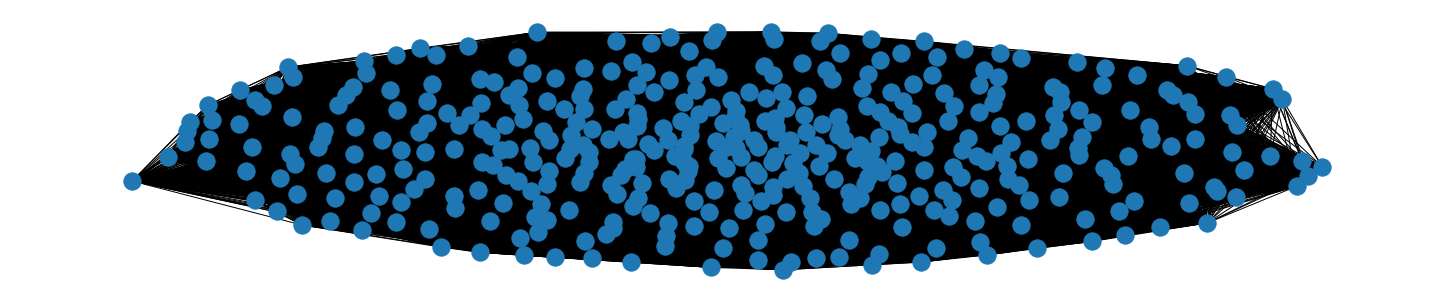

In [ ]:
import networkx as nx 
grafo = nx.from_numpy_array(FC)
Gcc = sorted(nx.connected_components(grafo), key=len, reverse=True)
grafo = grafo.subgraph(Gcc[0])
nx.draw(grafo)


In [ ]:
nodos = list(grafo.nodes())
for j in range(len(nodos)):
  grafo.nodes[nodos[j]]['area'] = sarea[j]

In [ ]:
nx.write_graphml(grafo,'/gdrive/Shareddrives/NoNameGroup - NMA/Resultados/Redes funcionales/FC_reward.graphml')